In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import linalg

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

## Import data

In [27]:
def plot(img):
    plt.figure(1)
    plt.imshow(img, cmap='Greys_r')
    
def comparePlot(original_image, img):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(original_image, cmap='Greys_r')    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(img, cmap='Greys_r') 

def comparePlotList(original_image, imgList, lambdas, m, n):
    fig = plt.figure(figsize=(16, 8))
    imgList = [original_image] + imgList
    lambdas = [-1] + lambdas
    for i in range(len(imgList)):
        ax1 = fig.add_subplot(1, len(imgList), i + 1)
        ax1.set_title("lambda = "+ str(lambdas[i]))
        ax1.imshow(imgList[i], cmap='Greys_r')
    s

In [199]:
def rescale(img, targetMin = 0.0, targetMax = 1.0):
    result = np.copy(img)
    minV = float('inf')
    maxV = -float('inf')
    for _, x in np.ndenumerate(result):
        minV = min(minV, x)
        maxV = max(maxV, x)
    for i, x in np.ndenumerate(result):
        result[i] = targetMin + (x - minV)*(targetMax- targetMin)/(maxV - minV)
    return result

def clip(img, targetMin = 0.0, targetMax = 1.0):
    result = np.copy(img)
    result[result < targetMin] = targetMin
    result[result > targetMax] = targetMax
    return result

def shiftAndNormalize(img, targetMean):
    mu = np.mean(img)
    result = np.copy(img) - mu
    maxI, minI = np.max(result), np.min(result)
    s1, s2 = (1.0 - targetMean) / maxI, - targetMean / minI
    result = min(s1, s2) * result + targetMean
    return result

Original image : shape = (273, 410, 3), data type = float32.


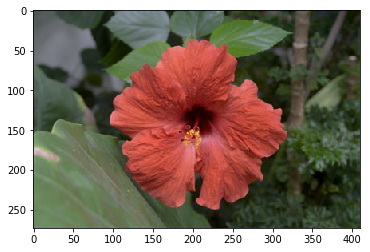

In [4]:
image_path = "flower.png"
original_image = mpimg.imread(image_path)
plot(original_image)
m, n = original_image.shape[0], original_image.shape[1]
print(
    "Original image : shape = {s}, data type = {dt}.".format(
        s=original_image.shape, dt=original_image.dtype))

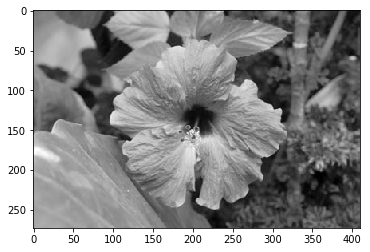

In [5]:
red  = original_image[:, :, 0]
green = original_image[:, :, 1]
blue = original_image[:, :, 2]
grayscale = (red + green + blue) / 3
plot(grayscale)

## Build WLS linear system

In [6]:
def w_frac(i, j, gi, gj, alpha_s, alpha_r):
    imj = i - j
    gimgj = gi - gj
    return 1 / ((np.dot(imj, imj) ** (alpha_s / 2) + 0.0001) * (np.dot(gimgj, gimgj) ** (alpha_r / 2) + 0.0001))

def w_exp(i, j, gi, gj, sigma_s, sigma_r):
    imj = i - j
    gimgj = gi - gj
    return np.e**(- np.dot(imj, imj) / (2 * sigma_s**2)) * np.e(- np.dot(gimgj, gimgj) / (2 * sigma_r**2))

In [7]:
def buildA(img, lambda_, r, par1, par2, useFracWeights=True):

    m , n = img.shape[0], img.shape[1] 
    size = m * n

    rowInd = []
    colInd = []
    data = []


    for i in range(m):
        mink = max(i - r, 0)
        for j in range(n):
            minl = max(j - r, 0)
            I = i * n + j
            tot = 0
            for k in range(mink, min(i + r + 1, m)):
                for l in range(minl, min(j + r + 1, n)):
                    J = k * n + l
                    if I != J:
                        if (useFracWeights):
                            val = lambda_ * w_frac(np.array([i, j]), np.array([k, l]), 
                                           original_image[i, j], original_image[k, l], par1, par2)
                        else:
                            val = lambda_ * w_exp(np.array([i, j]), np.array([k, l]), 
                                           original_image[i, j], original_image[k, l], par1, par2)
                        tot += val
                        rowInd.append(I)
                        colInd.append(J)
                        data.append(-val)
            rowInd.append(I)
            colInd.append(I)
            data.append(tot + 1)
        if i % 100 == 0 : print(i)
   
    return sp.coo_matrix((data, (rowInd, colInd)), shape=(size, size))

In [8]:
lambdas = [0.1, 0.4]
Us = []
r = 1
alphas = [1.2, 1.4]
for lambda_, alpha in zip(lambdas, alphas):
    print("Alpha : {}, Lambda : {}".format(alpha, lambda_))
    A = buildA(red, lambda_, r, alpha, alpha)
    Ur = sp.linalg.spsolve(A, red.flatten())
    A = buildA(green, lambda_, r, alpha, alpha)
    Ug = sp.linalg.spsolve(A, green.flatten())
    A = buildA(blue, lambda_, r, alpha, alpha)
    Ub = sp.linalg.spsolve(A, blue.flatten())
    U = np.zeros((m, n, 3))
    U[:, :, 0] = Ur.reshape((m, n))
    U[:, :, 1] = Ug.reshape((m, n))
    U[:, :, 2] = Ub.reshape((m, n))
    Us.append(U)

Alpha : 1.2, Lambda : 0.1
0
100
200


C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


0
100
200
0
100
200
Alpha : 1.4, Lambda : 0.4
0
100
200
0
100
200
0
100
200


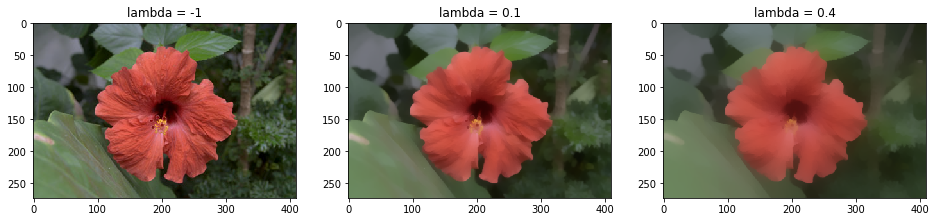

In [9]:
comparePlotList(original_image, Us, lambdas, m, n)

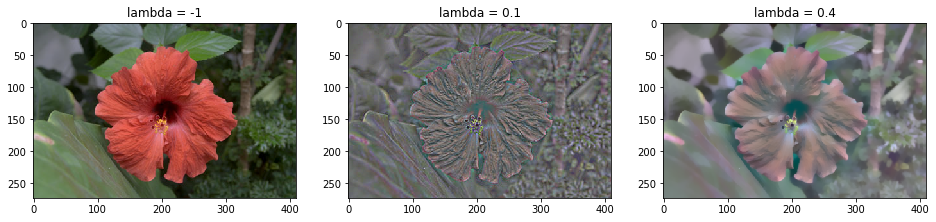

In [89]:
details = []
rescaledDetails = []
prev = original_image
for U in Us:
    D = prev - U
    details.append(D)
    rescaledDetails.append(rescale(D, 0, 1))
    prev = U
base = Us[len(Us) - 1]
comparePlotList(original_image, rescaledDetails, lambdas, m, n)

In [23]:
def sigmoid(a,x):
    return 1.0 / (1.0 + np.exp(-a * x))

[0.10679536 0.0666125  0.05828048] [0.81786272 0.63287743 0.54466821] [0.46232904 0.34974496 0.30147434]
[0.10689347 0.06708957 0.05939105] [0.81776462 0.63240036 0.54355764] [0.46232904 0.34974496 0.30147434]


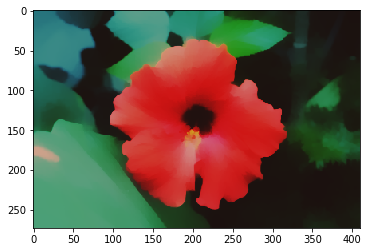

In [185]:
minB, maxB = np.min(base, axis=(0,1)), np.max(base, axis=(0,1))
muB = 0.5*(minB + maxB)
print(minB, maxB, muB)
testImage = minB + (maxB - minB) * sigmoid(25.0, base - muB)
plot(testImage)
minB, maxB = np.min(testImage, axis=(0,1)), np.max(testImage, axis=(0,1))
muB = 0.5*(minB + maxB)
print(minB, maxB, muB)

In [211]:
def multiScaleCorrection(base, details, baseExposure, baseBoost, detailBoosts):
    minB, maxB = np.min(base, axis=(0,1)), np.max(base, axis=(0,1))
    muB = 0.5*(minB + maxB)
    result = np.full(base.shape, 0.0)
    result += minB + (maxB - minB) * sigmoid(baseBoost, baseExposure * (base - muB))
    for D, d in zip(details, detailBoosts):
        minD, maxD = np.min(D, axis=(0,1)), np.max(D, axis=(0,1))
        muD = 0.5*(minD + maxD)
        result += minD + (maxD-minD)*sigmoid(d, D - muD)
        #result += sigmoid(d, D)
    return result

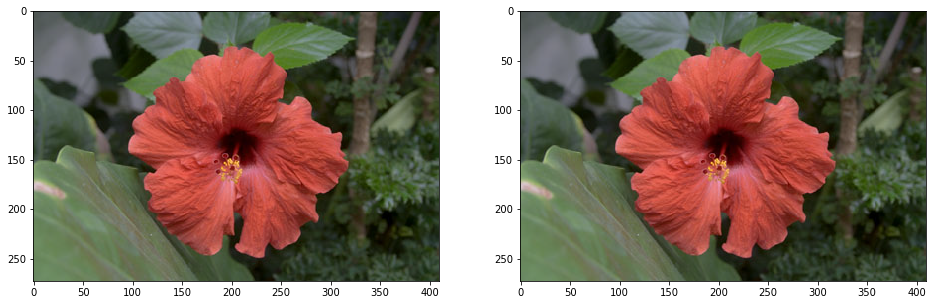

In [212]:
testImage = np.copy(base)
for D in details:
    testImage += D
comparePlot(original_image, testImage)

0.10600929992061181
0.829473792129596
0.3400533737530043
0.3172105
0.3172104954719543


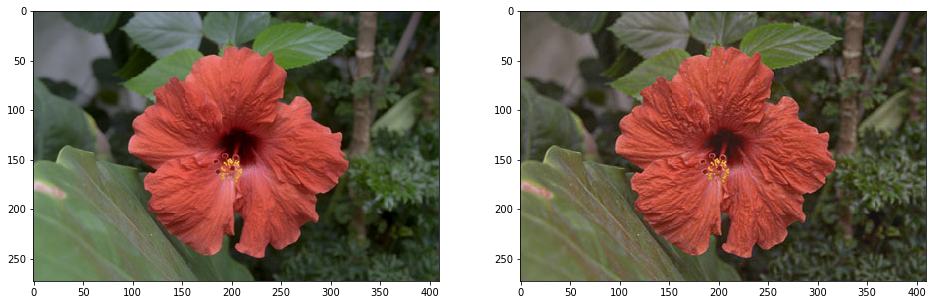

In [219]:
enhanced = multiScaleCorrection(base, details, 1.0, 4.0, [15.0, 4.0])
print(np.min(enhanced))
print(np.max(enhanced))
print(np.mean(enhanced))
mu = np.mean(original_image)
testImage = shiftAndNormalize(enhanced, mu)
print(mu)
print(np.mean(testImage))
comparePlot(original_image, testImage)

In [ ]:
def enhancementRoutine(imagePath):
    original_image = mpimg.imread(imagePath)
    m, n = original_image.shape[0], original_image.shape[1]
    print(
    "Original image : shape = {s}, data type = {dt}.".format(
        s=original_image.shape, dt=original_image.dtype))
    
    red  = original_image[:, :, 0]
    green = original_image[:, :, 1]
    blue = original_image[:, :, 2]
    grayscale = (red + green + blue) / 3
    
    lambdas = [0.1, 0.4]
    Us = []
    r = 1
    alphas = [1.2, 1.4]
    for lambda_, alpha in zip(lambdas, alphas):
        print("WLS with parameters : alpha = {}, lambda = {}".format(alpha, lambda_))
        print("Building system for red component...")
        A = buildA(red, lambda_, r, alpha, alpha)
        print("Solving system for red component...")
        Ur = sp.linalg.spsolve(A, red.flatten())
        print("Building system for green component...")
        A = buildA(green, lambda_, r, alpha, alpha)
        print("Solving system for green component...")
        Ug = sp.linalg.spsolve(A, green.flatten())
        print("Building system for blue component...")
        A = buildA(blue, lambda_, r, alpha, alpha)
        print("Solving system for blue component...")
        Ub = sp.linalg.spsolve(A, blue.flatten())
        U = np.zeros((m, n, 3))
        U[:, :, 0] = Ur.reshape((m, n))
        U[:, :, 1] = Ug.reshape((m, n))
        U[:, :, 2] = Ub.reshape((m, n))
        Us.append(U)
    
    print("Multi-scale edge-preserving smoothing results :")
    comparePlotList(original_image, Us, lambdas, m, n)
    
    details = []
    rescaledDetails = []
    prev = original_image
    for U in Us:
        D = prev - U
        details.append(D)
        rescaledDetails.append(rescale(D, 0, 1))
        prev = U
    base = Us[len(Us) - 1]
    print("Multi-scale detail extraction results :")
    comparePlotList(original_image, rescaledDetails, lambdas, m, n)
    
    enhanced = multiScaleCorrection(base, details, 1.0, 4.0, [15.0, 4.0])
    mu = np.mean(original_image)
    testImage = shiftAndNormalize(enhanced, mu)
    print("Image enhancement result :")
    comparePlot(original_image, testImage)

In [220]:
from utils import *

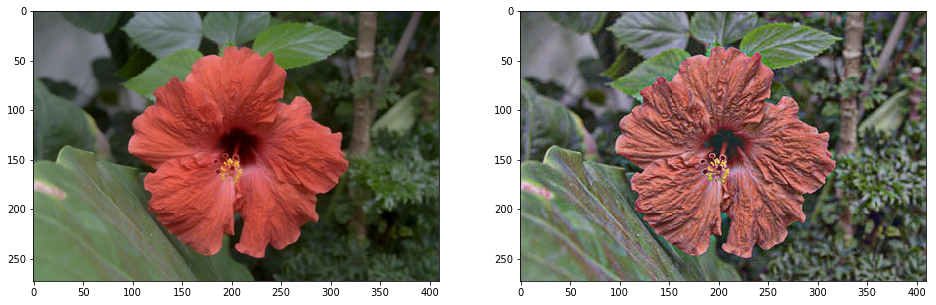

In [225]:
enhanced = multiScaleCorrection(base, details, 1.0, 1.0, [25.0, 1.0])
comparePlot(original_image, rescale(enhanced))

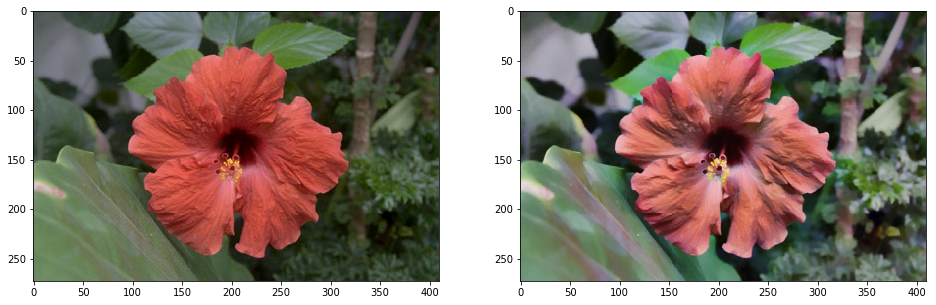

In [226]:
enhanced = multiScaleCorrection(base, details, 1.0, 1.0, [1.0, 40.0])
comparePlot(original_image, rescale(enhanced))

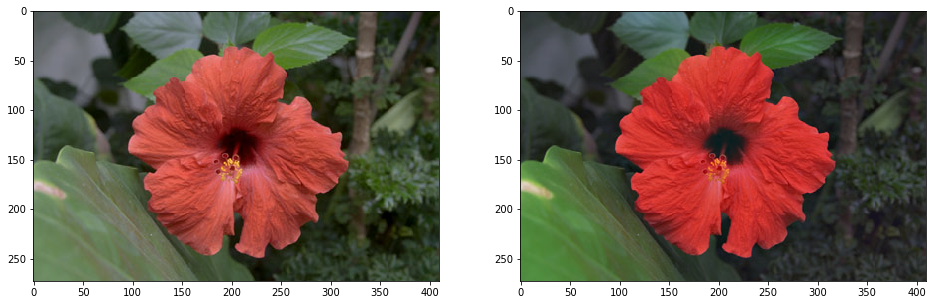

In [227]:
enhanced = multiScaleCorrection(base, details, 1.0, 15.0, [4.0, 1.0])
comparePlot(original_image, rescale(enhanced))